In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pyomo.environ as pyo
import time
import tqdm, random

$$Maximize\ \sum_i x_i$$
s.t. 
$$\sum_{i<j}^I x_i \leq j^2 \ \forall \ j$$

In [17]:
def getRandomIndices(mx,n):
    nums = np.random.randint(0,mx,n)
    return nums

def constructModel(n):
    model = pyo.ConcreteModel()
    
    I = range(n)
    model.I = pyo.Set(initialize=I)

    model.x = pyo.Var(model.I, domain=pyo.NonNegativeReals)

    model.objFunc = pyo.Objective(
        expr = sum([model.x[i] for i in model.I]),
        sense = pyo.maximize
    )
    
    np.random.seed(1)

    def constr(m,ii):
        indexs = getRandomIndices(n,int(n/2))
        
        lhs = 0
        for i in indexs:
            lhs += m.x[i] * np.random.uniform()
        rhs = np.random.uniform()
        return lhs <= rhs

    model.constraint = pyo.Constraint(model.I, rule=constr)
    return model

In [3]:
def rawStart(model):
    pyo.SolverFactory('gurobi').solve(model)#.write()
    # model.objFunc.display()
    # model.x.display()

In [4]:
SOLUTION = None

def setSolution(n):
    global SOLUTION
    
    model = constructModel(n)
    pyo.SolverFactory('gurobi').solve(model)
    SOLUTION = np.zeros(n)
    for i in range(n):
        SOLUTION[i] = pyo.value(model.x[i])

def warmStart(model,n,fracToStart=1,variation=0):
    global SOLUTION

    for i in range(n):
        if np.random.uniform() < fracToStart:
            if variation != 0:
                model.x[i] = SOLUTION[i] + np.random.randint(-variation,variation)
            else:
                model.x[i] = SOLUTION[i]
        

    pyo.SolverFactory('gurobi').solve(model, warmstart=True)#.write()
    # model.objFunc.display()
    # model.x.display()

In [5]:
def timeFunc(func,args=(),nExec=25):
    tStart = time.time()
    for i in range(nExec):
        func(*args)
    tEnd = time.time()
    return (tEnd - tStart) / nExec

In [ ]:
raws = []
warms = []

nTests = 1000
nExec = 1

pbar = tqdm.tqdm(range(nTests))
    
class RNG:
    def __init__(self):
        self.seed = time.time()
    def get(self):
        self.seed += 1
        a = self.seed * 15485863
        return (a * a * a % 2038074743) / 2038074743
    
myRNG = RNG()
    
def myRandomChoice(lst):
    i = int(myRNG.get() * len(lst))
    return lst[i]

for i in pbar:
    nVar = myRandomChoice(np.logspace(1,3,100,dtype=int))
    useRaw = myRandomChoice([True,False])
    desc = "Now Running {} test with {} variables: gen...".format("raw" if useRaw else "warm", nVar)
    pbar.set_description(desc)
    
    if useRaw:
        model = constructModel(nVar)
        desc += "Opt..."
        pbar.set_description(desc)
        raws.append([nVar,timeFunc(rawStart,args=(model,),nExec=nExec)])
    else:
        setSolution(nVar)
        model = constructModel(nVar)
        desc += "Opt..."
        pbar.set_description(desc)
        warms.append([nVar,timeFunc(warmStart,args=(model,nVar,),nExec=nExec)])
        
pbar.close()

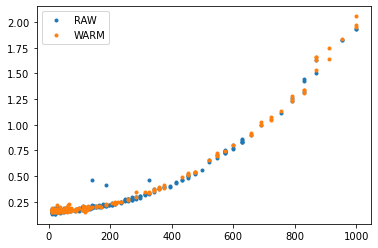

In [22]:
plt.plot([x[0] for x in raws],[x[1] for x in raws],".",label="RAW")
plt.plot([x[0] for x in warms],[x[1] for x in warms],".",label="WARM")
#plt.xscale("log")
plt.legend()